In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.engine import data_adapter
from tensorflow.keras import backend as K
import os, sys
os.mkdir('/kaggle/working/ckpts/')
sys.path.append('../input/boneage-ckpts')
sys.path.append('../input/hdaproject2021-codes/')
sys.path.append('../input/temppp/')

In [39]:
train_csv_directory = '../input/hdadataset2021/Bone Age Datasets/Bone Age Training Set/'
train_directory = '../input/hdadataset2021/Bone Age Datasets/Bone Age Training Set/boneage-training-dataset/'
df_train = pd.read_csv(train_csv_directory + 'train.csv')

val_csv_directory = '../input/hdadataset2021/'
val_directory = '../input/hdadataset2021/boneage-validation-dataset/'
df_val = pd.read_csv(val_csv_directory + 'Validation Dataset.csv')

In [41]:
ids = df_train['id'].values.astype(str)
labels_train = df_train['male'].values.astype(float)
ages_train = df_train['boneage'].values.astype(float)
train_ds = tf.data.Dataset.from_tensor_slices((ids, labels_train, ages_train))


ids = df_val['Image ID'].values.astype(str)
labels_val = df_val['male'].values.astype(float)
ages_val = df_val['Bone Age (months)'].values.astype(float)
val_ds = tf.data.Dataset.from_tensor_slices((ids, labels_val, ages_val))

IMG_SIZE = (300, 300, 1)
BATCH_SIZE = 32

# Labels and ages distribution

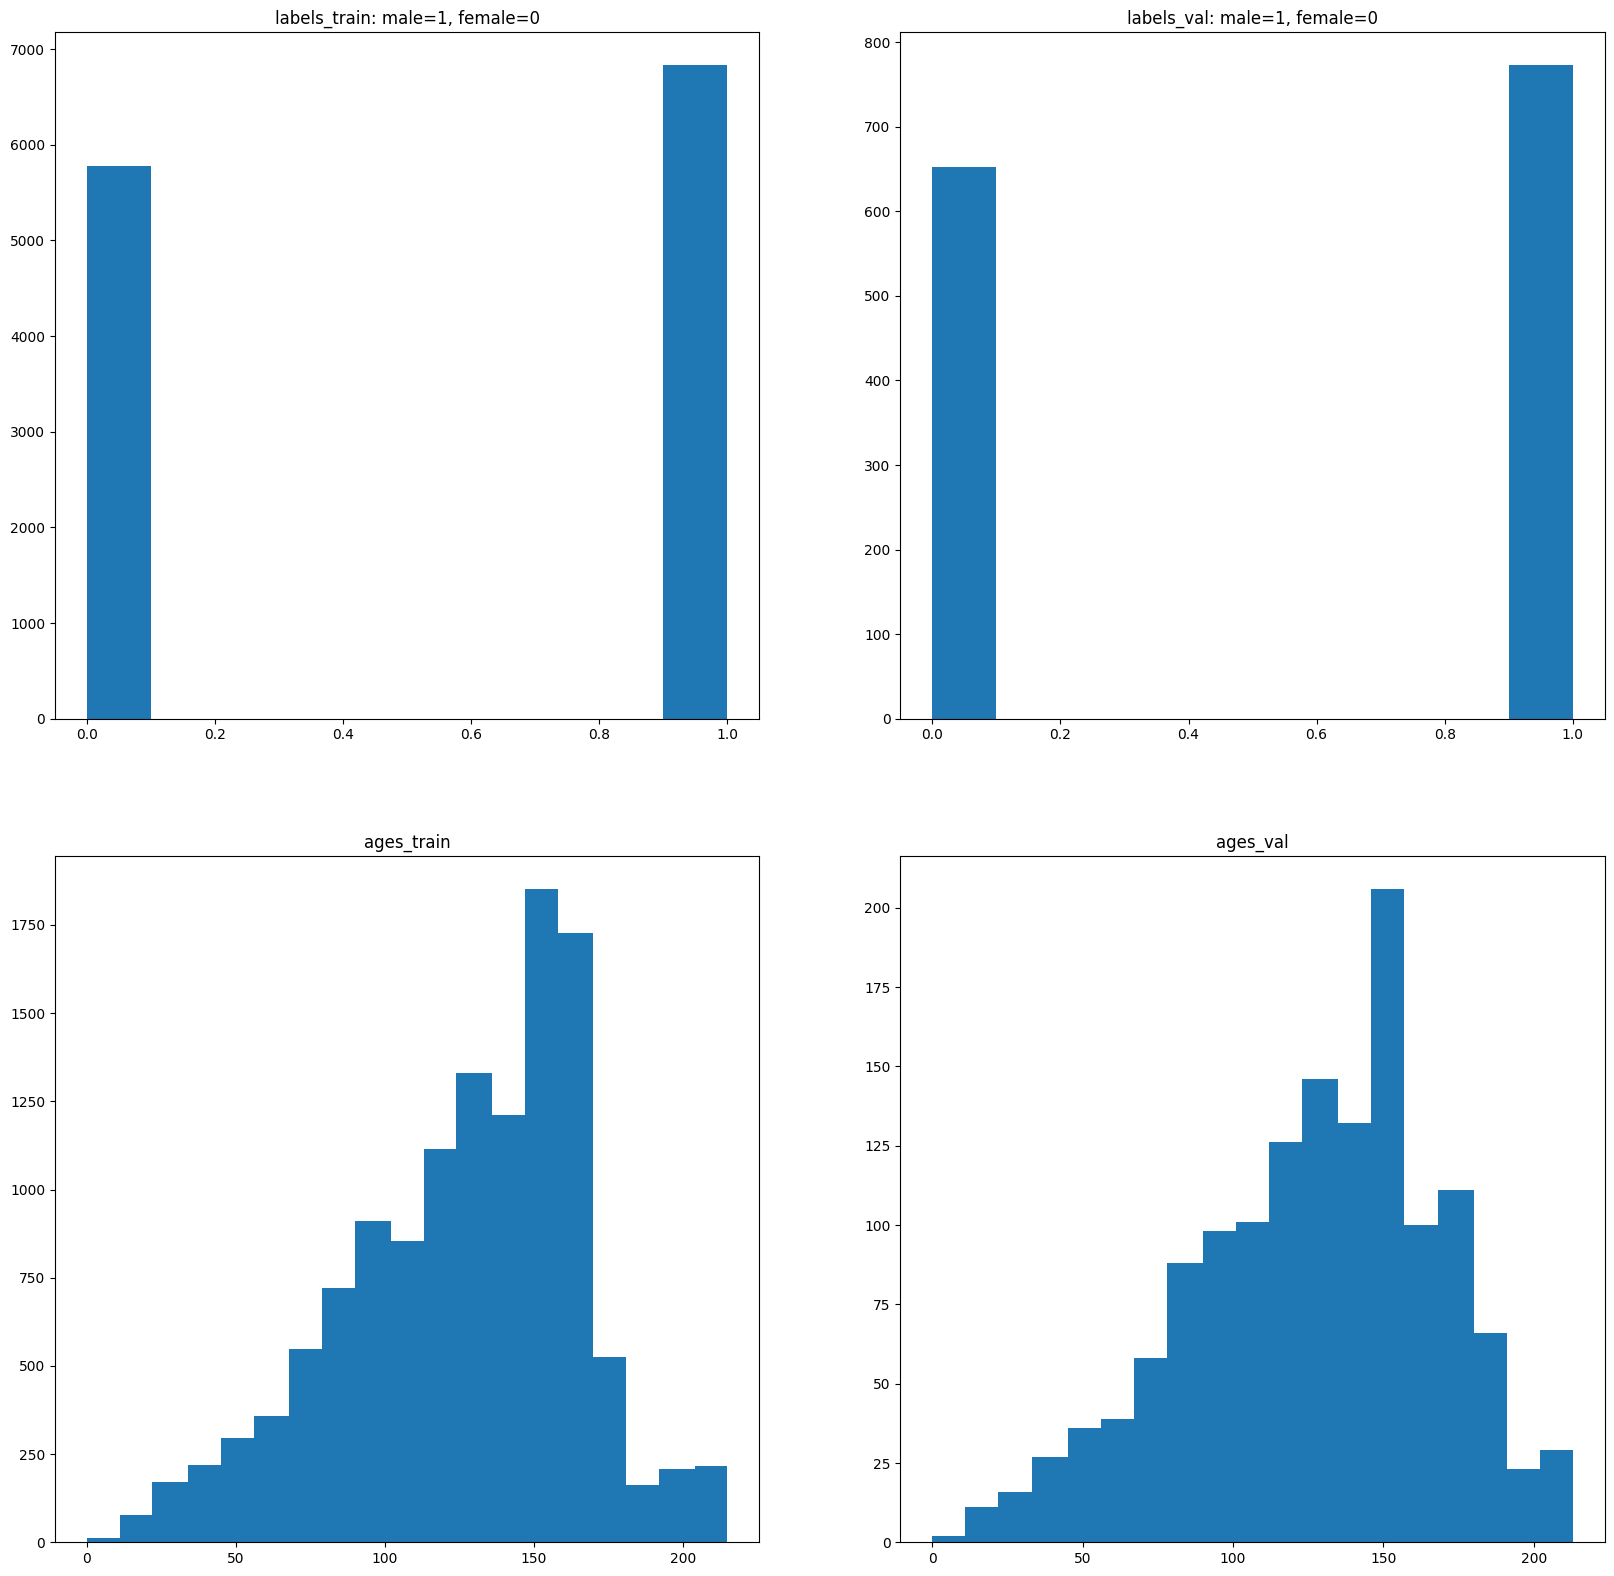

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20),dpi=100)
_ = plt.subplot(2,2,1); _ = plt.hist(labels_train); plt.title('labels_train: male=1, female=0')
_ = plt.subplot(2,2,2); _ = plt.hist(labels_val); plt.title('labels_val: male=1, female=0')
_ = plt.subplot(2,2,3); _ = plt.hist(ages_train, bins=np.arange(20)*int(max(ages_train)-min(ages_train))//20); plt.title('ages_train')
_ = plt.subplot(2,2,4); _ = plt.hist(ages_val, bins=np.arange(20)*int(max(ages_val)-min(ages_val))//20); plt.title('ages_val')
plt.savefig('distribution.png')

In [43]:
def read_train_image(image_file, label, age):
    image = tf.io.read_file(train_directory + image_file+ '.png')
    image = tf.io.decode_png(image, channels=1)
    return image, [label], [age] #lists are necessary for training the model (otherwise dims are unknown)

def read_val_image(image_file, label, age):
    image = tf.io.read_file(val_directory + image_file + '.png')
    image = tf.io.decode_png(image, channels=1)
    return image, [label], [age] #lists are necessary for training the model (otherwise dims are unknown)

resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(height=IMG_SIZE[0], width=IMG_SIZE[1])
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
zoom_layer = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,-0.3),
                                                                   width_factor=(0.2,-0.3),
                                                                  fill_mode='constant')
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')

def augment(image, label, age):
    # data augmentation here
    image = zoom_layer(image)
    image = flip_layer(image)
    return image, label, age

In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #tf.data.AUTOTUNE
train_ds = train_ds.map(read_train_image).map(lambda image,label,age: (normalization_layer((resize_layer(image))), label, age)).cache('../input/hdaproject2021-codes/train_cache_300')
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).map(augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(read_val_image).map(lambda image,label,age: (normalization_layer(resize_layer(image)), label, age)).cache('../input/hdaproject2021-codes/val_cache_300')
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE)

# Load test set

In [47]:
test_directory = '../input/hdadataset2021/Bone Age Datasets/Bone Age Test Set/Test Set Images/'

df_test = pd.read_csv('../input/hdaproject2021-codes/test.csv')

ids = df_test['id'].values.astype(str)
labels = (df_test['Sex'].values == 'M').astype(float)

# replace ',' with '.' and convert to float
ages_str = df_test['boneage'].values
ages = np.empty_like(ages_str)
for i, item in enumerate(ages_str):
    replaced = item.replace(',','.')
    replaced_float = float(replaced)
    ages[i] = replaced_float
ages = ages.astype(float)

test_ds = tf.data.Dataset.from_tensor_slices((ids, labels, ages))

def read_test_image(image_file, label, age):
    image = tf.io.read_file(test_directory + image_file + '.png')
    image = tf.io.decode_png(image, channels=1)
    return image, [label], [age] #lists are necessary for training the model (otherwise dims are unknown)

test_ds = test_ds.map(read_test_image).map(lambda image,label,age: (normalization_layer(resize_layer(image)), label, age)).cache()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

test_iterator = test_ds.as_numpy_iterator()
N = 200 #number of samples
test_images = np.empty(shape=(N, IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)
test_labels = np.empty(shape=(N,), dtype=np.float32)
test_ages = np.empty(shape=(N,), dtype=np.float32)
for i, item in enumerate(test_iterator):
    test_images[i] = item[0]
    test_labels[i] = item[1]
    test_ages[i] = item[2]
    
print(test_images.shape)
print(test_labels.shape)
print(test_ages.shape)

(200, 300, 300, 1)
(200,)
(200,)


# Boneage Model

In [45]:
from InceptionV3_2_initializer import InceptionV3

class BoneAgeInception(tf.keras.Model):  
    def __init__(self, gender=True, beta=1, initializer=tf.keras.initializers.HeNormal()):
        super(BoneAgeInception, self).__init__()
        
        model = InceptionV3(
                                include_top=False,
                                weights=None,
                                input_shape=IMG_SIZE,
                                beta=beta, initializer=initializer)
                
        
        if gender:
            gender_input = tf.keras.Input(shape=(1))
            gender_output = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=initializer)(gender_input)
            
            model_global_avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
            
            concat_output = tf.keras.layers.Concatenate(name='gender_and_feat._concat')([model_global_avg, gender_output])
            
            overall_output = tf.keras.layers.Dense(1,activation='relu', kernel_regularizer='l2', kernel_initializer=initializer)(concat_output)
            
            self.model = tf.keras.Model(inputs=[model.input, gender_input], outputs = overall_output)
        else:
            pass #COMPLETE!
                
        
        
    def call(self, x, training=False):
        imgs, labels = x
        
        y = self.model([imgs, labels],training)
       
        return y

    def train_step(self, data):
        
        data = data_adapter.expand_1d(data)
        imgs, labels, ages = data
        
        with tf.GradientTape() as tape:
            y_pred = self((imgs, labels), training=True)  # Forward pass

            loss = self.compiled_loss(ages, y_pred)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(ages, y_pred)
        _dict = {m.name: m.result() for m in self.metrics}
        
        return _dict

    def test_step(self, data):
        
        data = data_adapter.expand_1d(data)
        imgs, labels, ages = data

        y_pred = self((imgs, labels), training=False)  # Forward pass

        loss = self.compiled_loss(ages, y_pred)

        self.compiled_metrics.update_state(ages, y_pred)
        _dict = {m.name: m.result() for m in self.metrics}
        
        return _dict
    
    def summary(self):
        print(self.model.summary())

# CAM

In [54]:
bonage_inception = BoneAgeInception(beta=1.2)

bonage_inception.compile(loss='mse', metrics=['mae'])

_ = bonage_inception.fit(val_ds.take(1), epochs=1)
bonage_inception.load_weights('../input/hdaproject2021-codes/best_val_inception_80ep.h5')

1/1 [==============================] - 49s 49s/step - loss: 12577.7344 - mae: 96.6133


In [55]:
bonage_inception_pred = bonage_inception.predict((test_images, test_labels))
print(f'Test accuracy: {np.mean(np.abs(bonage_inception_pred.squeeze() - test_ages.squeeze()))}')

Test accuracy: 6.759592056274414


In [66]:
last_layer = bonage_inception.model.layers[-1]
n_channels = 2454
weights = last_layer.get_weights()[0][0:n_channels]
last_conv = bonage_inception.model.get_layer('mixed8-2')

In [235]:
samples = list(val_ds.take(3).unbatch())[44:50]
images = np.empty(shape=(6, IMG_SIZE[0], IMG_SIZE[1], 1))
labels = np.empty(shape=6)
ages = np.empty(shape=6)
for i,sample in enumerate(samples):
    images[i] = sample[0]
    labels[i] = sample[1]
    ages[i] = sample[2]

In [236]:
conv_output = K.function([bonage_inception.model.input], [last_conv.output])
conv_output = conv_output((images, labels))[0]

In [237]:
cams = conv_output * weights.squeeze()
cams = np.sum(cams, axis=-1)
cams_resized = np.empty(shape=(6, IMG_SIZE[0], IMG_SIZE[1], 1))
for i, cam in enumerate(cams):
    cams_resized[i] = resize_layer(np.expand_dims(cam,axis=-1))
    cams_resized[i] = cams_resized[i] / np.max(cams_resized[i])

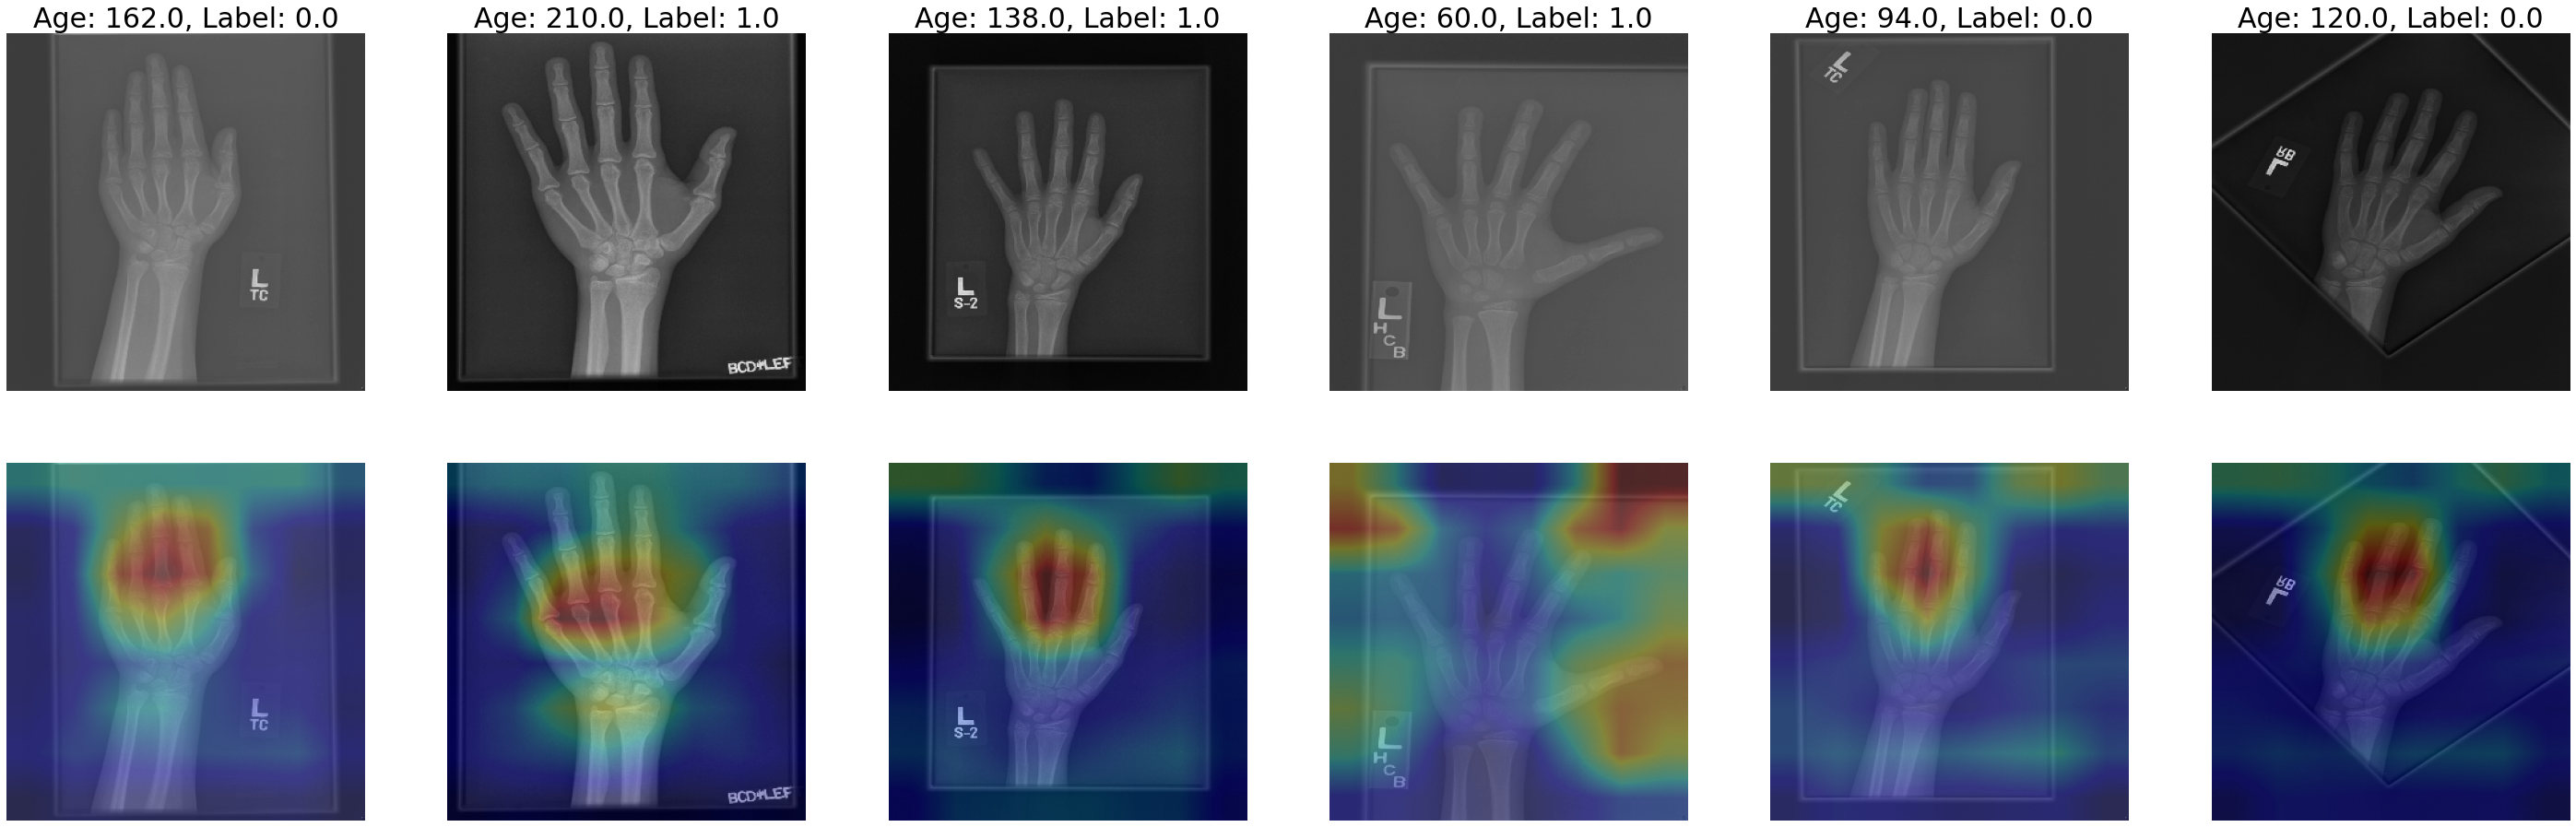

In [251]:
fig = plt.figure(figsize=(50,50))
for i, image in enumerate(images):
    _ = plt.subplot(6,6,i+1)
    _ = plt.imshow(image, vmin=0, vmax=1, cmap='gray')
    _ = plt.axis('off')
    _ = plt.title('Age: '+ str(ages[i]) + ', Label: '+str(labels[i]),fontsize=30)
    
    _ = plt.subplot(6,6,6+i+1)
    _ = plt.imshow(image, vmin=0, vmax=1, cmap='gray')
    _ = plt.axis('off')
    _ = plt.imshow(cams_resized[i], cmap='jet', alpha=0.3)
plt.savefig('cams.png')

# Final model 

In [46]:
class BoneAgeNet(tf.keras.Model):  
    def __init__(self, gender=True):
        super(BoneAgeNet, self).__init__()
        
        model = BoneAgeInception(beta=1.4)
        
        #model.compile(optimizer='adam',loss='mse')
        #_ = model.fit(val_ds.take(1), verbose=2)
        #model.load_weights('./ckpts/inception_modified/best_val_inception_80ep.h5')
        #model.trainable=False
        
        for layer in model.model.layers:
            if layer.name.startswith('global_average'):
                global_avg_output = layer.output
                break
                
        
        if gender:
            initializer = tf.keras.initializers.HeNormal()
            gender_input = model.model.inputs[-1]
            gender_output = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=initializer)(gender_input)
            
            global_avg_output = tf.keras.layers.Dropout(0.3)(global_avg_output)
            
            concat_output = tf.keras.layers.Concatenate(name='gender_and_feat._concat')([global_avg_output, gender_output])
            
            dense_output = tf.keras.layers.Dense(3000,activation='relu', kernel_regularizer='l2', kernel_initializer=initializer)(concat_output)
            
            overall_output = tf.keras.layers.Dense(1,activation='relu', kernel_regularizer='l2', kernel_initializer=initializer)(dense_output)
            
            self.model = tf.keras.Model(inputs=model.model.inputs, outputs = overall_output)
        else:
            pass #COMPLETE!
                
        
        
    def call(self, x, training=False):
        imgs, labels = x
        
        y = self.model([imgs, labels],training)
       
        return y

    def train_step(self, data):
        
        data = data_adapter.expand_1d(data)
        imgs, labels, ages = data
        
        with tf.GradientTape() as tape:
            y_pred = self((imgs, labels), training=True)  # Forward pass

            loss = self.compiled_loss(ages, y_pred)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(ages, y_pred)
        _dict = {m.name: m.result() for m in self.metrics}
        
        return _dict

    def test_step(self, data):
        
        data = data_adapter.expand_1d(data)
        imgs, labels, ages = data

        y_pred = self((imgs, labels), training=False)  # Forward pass

        loss = self.compiled_loss(ages, y_pred)

        self.compiled_metrics.update_state(ages, y_pred)
        _dict = {m.name: m.result() for m in self.metrics}
        
        return _dict
    
    def summary(self):
        print(self.model.summary())

In [48]:
bonagenet = BoneAgeNet()

bonagenet.compile(loss='mse', metrics=['mae'])

_ = bonagenet.fit(val_ds.take(1), epochs=1)
bonagenet.load_weights('../input/hdaproject2021-codes/best_val_bonagenet_100ep.h5')

1/1 [==============================] - 59s 59s/step - loss: 12552.2773 - mae: 96.5090


In [292]:
bonagenet_pred = bonagenet.predict((test_images, test_labels))
print(f'Test accuracy: {np.mean(np.abs(bonagenet_pred.squeeze() - test_ages.squeeze()))}')

Test accuracy: 5.603835582733154


# Model prediction on the three datasets

In [267]:
N_val = len(ages_val)
val_images = np.empty(shape=(N_val, IMG_SIZE[0], IMG_SIZE[1], 1))
val_labels = np.empty(shape=N_val)
val_ages = np.empty(shape=N_val)
for i, element in enumerate(val_ds.unbatch().as_numpy_iterator()):
    val_images[i] = element[0]
    val_labels[i] = element[1]
    val_ages[i] = element[2]

In [268]:
print(val_images.shape)
print(val_labels.shape)
print(val_ages.shape)

(1425, 300, 300, 1)
(1425,)
(1425,)


In [269]:
bonagenet_pred_val = bonagenet.predict((val_images, val_labels))
print(f'Validation accuracy: {np.mean(np.abs(bonagenet_pred_val.squeeze() - val_ages.squeeze()))}')

Validation accuracy: 7.2163662974039715


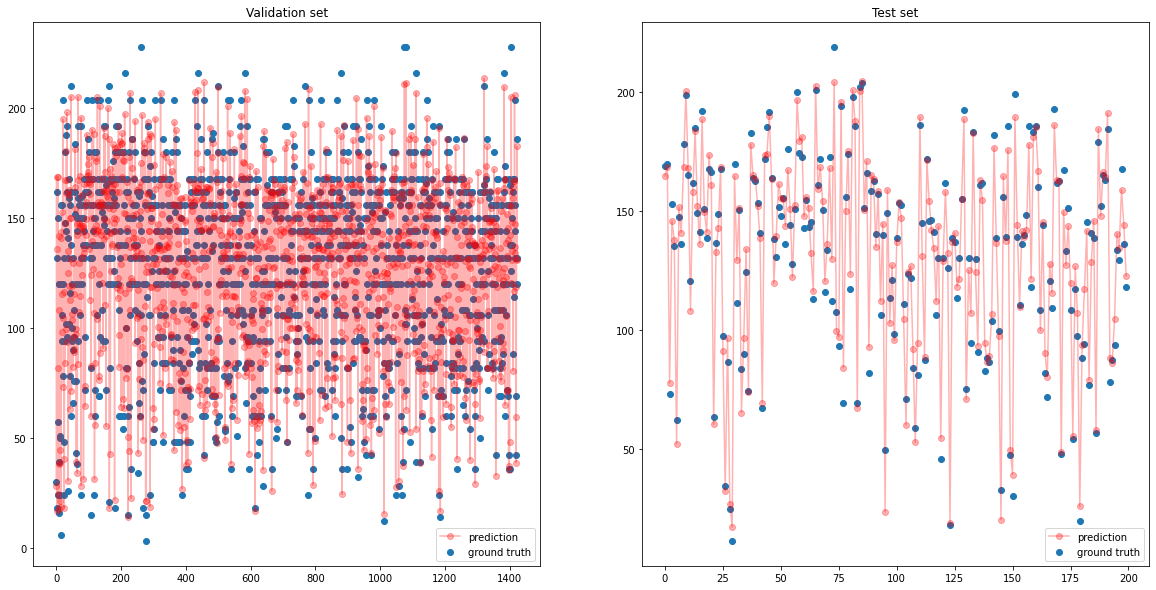

In [297]:
fig = plt.figure(figsize=(20,10))
_ = plt.subplot(1,2,1)
_ = plt.scatter(np.arange(N_val),val_ages, label='ground truth')
_ = plt.plot(bonagenet_pred_val, 'ro-', label='prediction', alpha=0.3)
_ = plt.legend(loc="lower right")
_ = plt.title('Validation set')

_ = plt.subplot(1,2,2)
_ = plt.scatter(np.arange(len(test_ages)),test_ages, label='ground truth')
_ = plt.plot(bonagenet_pred, 'ro-', label='prediction', alpha=0.3)
_ = plt.legend(loc="lower right")
_ = plt.title('Test set')

plt.savefig('predictions.png')